Episode 1000 completed, episode length = 200
Episode 2000 completed, episode length = 200
Episode 3000 completed, episode length = 200
Episode 4000 completed, episode length = 200
Episode 5000 completed, episode length = 129
Episode 6000 completed, episode length = 200
Episode 7000 completed, episode length = 187
Episode 8000 completed, episode length = 193
Episode 9000 completed, episode length = 200
Episode 10000 completed, episode length = 200
Episode 11000 completed, episode length = 200
Episode 12000 completed, episode length = 200
Episode 13000 completed, episode length = 200
Episode 14000 completed, episode length = 200
Episode 15000 completed, episode length = 200
Episode 16000 completed, episode length = 116
Episode 17000 completed, episode length = 200
Episode 18000 completed, episode length = 200
Episode 19000 completed, episode length = 200
Episode 20000 completed, episode length = 133
Episode 21000 completed, episode length = 137
Episode 22000 completed, episode length = 2

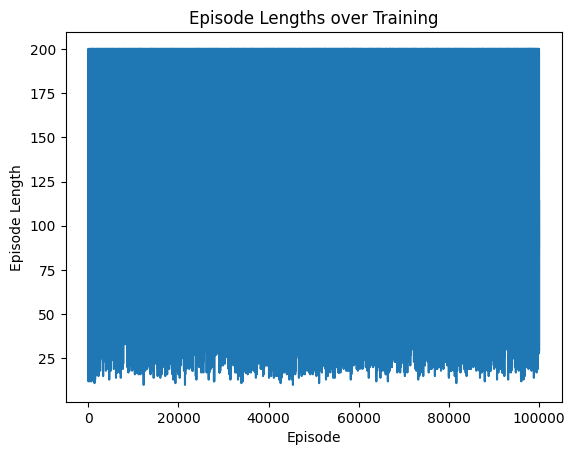

In [14]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Helper functions for discretization ---
# Define discretization parameters:
NUM_BINS = (6, 6, 12, 12)  # Number of bins for each of the 4 state dimensions

# Define approximate bounds for each state variable:
# [cart position, cart velocity, pole angle, pole angular velocity]
state_bounds = [
    (-4.8, 4.8),       # cart position
    (-3.0, 3.0),       # cart velocity
    (-0.418, 0.418),   # pole angle (radians ~ 24 degrees)
    (-2.0, 2.0)        # pole angular velocity
]

def discretize_state(state):
    """
    Map a continuous state (a list or numpy array) into a tuple of discrete indices.
    """
    ratios = []
    for i in range(len(state)):
        # Clip state to within the bounds:
        clipped = np.clip(state[i], state_bounds[i][0], state_bounds[i][1])
        ratio = (clipped - state_bounds[i][0]) / (state_bounds[i][1] - state_bounds[i][0])
        ratios.append(ratio)
    new_state = tuple([int(round((NUM_BINS[i] - 1) * ratios[i])) for i in range(len(state))])
    # Ensure indices are within [0, NUM_BINS[i]-1]
    new_state = tuple([min(NUM_BINS[i]-1, max(0, new_state[i])) for i in range(len(state))])
    return new_state

# --- Monte Carlo Off-Policy Control Setup ---
env = gym.make("CartPole-v0")
actions = list(range(env.action_space.n))  # CartPole has 2 actions: 0 and 1

# Initialize Q(s,a), C(s,a) for weighted importance sampling, and target policy pi(s)
Q = {}
C = {}
pi = {}

# Initialize for each discretized state (using nested loops over bins)
for i in range(NUM_BINS[0]):
    for j in range(NUM_BINS[1]):
        for k in range(NUM_BINS[2]):
            for l in range(NUM_BINS[3]):
                s = (i, j, k, l)
                for a in actions:
                    Q[(s, a)] = 0.0
                    C[(s, a)] = 0.0
                # Initially, set the target policy arbitrarily (here, action 0)
                pi[s] = 0

# Define behavior policy b as an epsilon-soft policy
epsilon = 0.1

def behavior_policy(state_disc):
    """Return an action sampled from an epsilon-soft behavior policy."""
    if random.random() < epsilon:
        return random.choice(actions)
    else:
        # Greedy with respect to Q
        q_values = [Q[(state_disc, a)] for a in actions]
        max_q = max(q_values)
        greedy_actions = [a for a, q in zip(actions, q_values) if q == max_q]
        return random.choice(greedy_actions)

def target_policy(state_disc):
    """Return the greedy action with respect to Q (deterministic target policy)."""
    q_values = [Q[(state_disc, a)] for a in actions]
    max_q = max(q_values)
    greedy_actions = [a for a, q in zip(actions, q_values) if q == max_q]
    return random.choice(greedy_actions)

# --- MC Control using Weighted Importance Sampling (Off-Policy) ---
num_episodes = 100000
gamma = 0.9  # discount factor

# For logging
episode_lengths = []

for episode in range(num_episodes):
    # Generate an episode using behavior policy b
    episode_data = []  # will store tuples: (state_disc, action, reward)
    state, _ = env.reset()  # unpack observation and info
    state_disc = discretize_state(state)
    
    done = False
    while not done:
        action = behavior_policy(state_disc)
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated  # combine done and truncated flags
        next_state_disc = discretize_state(next_state)
        episode_data.append((state_disc, action, reward))
        state_disc = next_state_disc

    episode_lengths.append(len(episode_data))
    
    # Calculate return G and update Q using weighted importance sampling (first-visit MC)
    G = 0
    W = 1.0  # cumulative importance sampling ratio
    # Process the episode backwards:
    for t in reversed(range(len(episode_data))):
        s, a, r = episode_data[t]
        G = r + gamma * G  # compute return from time t
        
        # Check if (s, a) first occurred at time t in this episode
        if (s, a) not in [(x[0], x[1]) for x in episode_data[:t]]:
            # Update C(s, a) and Q(s, a)
            C[(s, a)] += W
            Q[(s, a)] += (W / C[(s, a)]) * (G - Q[(s, a)])
            # Update the target policy to be greedy with respect to Q
            pi[s] = target_policy(s)
            # If the action taken is not the one chosen by the target policy, stop updates for this episode
            if a != pi[s]:
                break
            # Update W (importance sampling ratio)
            # For epsilon-soft behavior, probability for greedy action is:
            b_prob = (1 - epsilon + epsilon / len(actions)) if a == target_policy(s) else (epsilon / len(actions))
            pi_prob = 1.0  # target policy is deterministic greedy
            W *= (pi_prob / b_prob)
            if W == 0:
                break

    if (episode + 1) % 1000 == 0:
        print(f"Episode {episode+1} completed, episode length = {len(episode_data)}")

# --- Testing the Learned Policy ---
# Test the target policy (greedy with respect to Q)
test_episodes = 20
test_lengths = []
for _ in range(test_episodes):
    state, _ = env.reset()
    state_disc = discretize_state(state)
    done = False
    steps = 0
    while not done and steps < 10000:
        a = target_policy(state_disc)
        state, reward, done, truncated, _ = env.step(a)
        done = done or truncated
        state_disc = discretize_state(state)
        steps += 1
    test_lengths.append(steps)

env.close()
print("Average steps balanced in test episodes:", np.mean(test_lengths))

# Plotting episode lengths during training (optional)
plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Lengths over Training")
plt.show()


In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Discretization helper function
def discretize(obs, bins):
    upper_bounds = [4.8, 5, 0.418, 5]
    lower_bounds = [-4.8, -5, -0.418, -5]
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((bins - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(bins - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

# Dynamic Programming - Value Iteration
def value_iteration(env, bins=10, gamma=0.99, theta=0.0001):
    V = defaultdict(float)
    policy = defaultdict(int)

    while True:
        delta = 0
        for obs in np.ndindex((bins, bins, bins, bins)):
            v = V[obs]
            q_values = []
            for action in [0, 1]:
                env.reset()
                env.env.state = [random.uniform(-0.05, 0.05) for _ in range(4)]
                disc_obs = obs
                env.env.state = [((o / (bins - 1)) * (ub - lb) + lb) for o, lb, ub in zip(disc_obs, [-4.8, -5, -0.418, -5], [4.8, 5, 0.418, 5])]
                next_obs, reward, done, _ = env.step(action)
                disc_next_obs = discretize(next_obs, bins)
                q_values.append(reward + gamma * V[disc_next_obs])
            V[obs] = max(q_values)
            policy[obs] = np.argmax(q_values)
            delta = max(delta, abs(v - V[obs]))
        if delta < theta:
            break
    return policy

# Monte Carlo Control with Epsilon-Greedy
def mc_control(env, bins=10, episodes=10000, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for i in range(episodes):
        obs = env.reset()
        episode = []
        done = False

        while not done:
            disc_obs = discretize(obs, bins)
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[disc_obs])
            next_obs, reward, done, _ = env.step(action)
            episode.append((disc_obs, action, reward))
            obs = next_obs

        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if not (state, action) in [(x[0], x[1]) for x in episode[:-1]]:
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

    policy = {state: np.argmax(actions) for state, actions in Q.items()}
    return policy

# Running the policies
def run_policy(env, policy, bins=10, episodes=10):
    for ep in range(episodes):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            disc_obs = discretize(obs, bins)
            action = policy.get(disc_obs, env.action_space.sample())
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print(f"Episode {ep + 1}: Total Reward: {total_reward}")
    env.close()




In [5]:
env = gym.make("CartPole-v0")

print("\nRunning Dynamic Programming (Value Iteration)...")
dp_policy = value_iteration(env)
run_policy(env, dp_policy)
env.close()


Running Dynamic Programming (Value Iteration)...


ValueError: too many values to unpack (expected 4)

In [ ]:
print("\nRunning Monte Carlo Control...")
mc_policy = mc_control(env)
run_policy(env, mc_policy)

env.close()

In [6]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Discretization helper function
def discretize(obs, bins):
    upper_bounds = [4.8, 5, 0.418, 5]
    lower_bounds = [-4.8, -5, -0.418, -5]
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((bins - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(bins - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

# Dynamic Programming - Value Iteration
def value_iteration(env, bins=10, gamma=0.99, theta=0.0001):
    V = defaultdict(float)
    policy = defaultdict(int)

    while True:
        delta = 0
        for obs in np.ndindex((bins, bins, bins, bins)):
            v = V[obs]
            q_values = []
            for action in [0, 1]:
                env.reset()
                env.env.state = [random.uniform(-0.05, 0.05) for _ in range(4)]
                disc_obs = obs
                env.env.state = [((o / (bins - 1)) * (ub - lb) + lb) for o, lb, ub in zip(disc_obs, [-4.8, -5, -0.418, -5], [4.8, 5, 0.418, 5])]
                next_obs, reward, done, _ = env.step(action)
                disc_next_obs = discretize(next_obs, bins)
                q_values.append(reward + gamma * V[disc_next_obs])
            V[obs] = max(q_values)
            policy[obs] = np.argmax(q_values)
            delta = max(delta, abs(v - V[obs]))
        if delta < theta:
            break
    return policy

# Monte Carlo Control with Epsilon-Greedy
def mc_control(env, bins=10, episodes=10000, gamma=0.99, epsilon=0.1):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    for i in range(episodes):
        obs = env.reset()
        episode = []
        done = False

        while not done:
            disc_obs = discretize(obs, bins)
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[disc_obs])
            next_obs, reward, done, _ = env.step(action)
            episode.append((disc_obs, action, reward))
            obs = next_obs

        G = 0
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if not (state, action) in [(x[0], x[1]) for x in episode[:-1]]:
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]

    policy = {state: np.argmax(actions) for state, actions in Q.items()}
    return policy

# Running the policies
def run_policy(env, policy, bins=10, episodes=10):
    for ep in range(episodes):
        obs = env.reset()
        total_reward = 0
        done = False
        while not done:
            disc_obs = discretize(obs, bins)
            action = policy.get(disc_obs, env.action_space.sample())
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            env.render()
        print(f"Episode {ep + 1}: Total Reward: {total_reward}")
    env.close()

if __name__ == "__main__":
    env = gym.make("CartPole-v0")

    print("\nRunning Dynamic Programming (Value Iteration)...")
    dp_policy = value_iteration(env)
    run_policy(env, dp_policy)

    print("\nRunning Monte Carlo Control...")
    mc_policy = mc_control(env)
    run_policy(env, mc_policy)

    env.close()



Running Dynamic Programming (Value Iteration)...


ValueError: too many values to unpack (expected 4)